In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve, make_scorer,f1_score
from sklearn.metrics import precision_recall_curve as PRC

### Utility Functions

In [2]:
def get_data_path(data_name="none", 
                  data_file_name="project_dataset.csv"):
    """  Gets the data path, specific to the project configuration.
    
    :return path to data
    """
    
    proj_dirs = os.getcwd().split("code")
    data_dir = os.path.join(proj_dirs[0], "data")
    data_path = os.path.join(data_dir,data_file_name)
    
    return data_path
# Sample a given number of points from the provided dataset with replacement. seed for repeatability
def get_dataFrame_sample(subset_size, df, seed):
    return df.sample(n=subset_size, random_state=seed, replace=True)

# Sample a given number of points from the provided dataset. seed for repeatability
def get_dataFrame_subset(subset_size, df, seed):
    return df.sample(n=subset_size, random_state=seed)

### Pre-processing

In [3]:
file_name = get_data_path()
# usecols=['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Flow Bytes/s', 'Label']
original_df = pd.read_csv(file_name, sep=',', encoding='utf-8', usecols=[' Flow Duration', ' Total Fwd Packets', 
                ' Total Backward Packets', ' Fwd Packet Length Mean', ' Bwd Packet Length Mean', 'Flow Bytes/s', 'Fwd Packets/s', ' Bwd Packets/s', ' Label']).dropna()
original_df = original_df.rename(columns={' Flow Duration':'flow_duration', ' Total Fwd Packets':'total_fwd_packets',
                                         ' Total Backward Packets':'total_bwd_packets', ' Fwd Packet Length Mean':'fwd_packet_length_mean',
                                         ' Bwd Packet Length Mean':'bwd_packet_length_mean', 'Flow Bytes/s':'flow_bytes/s',
                                         'Fwd Packets/s':'fwd_packets/s', ' Bwd Packets/s':'bwd_packets/s', ' Label':'label'})
# Remove leading/trailing whitespace




In [4]:
display(original_df.head())
display(original_df.describe())
display(original_df.info())

,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
0,113095465,48,24,201.416667,417.166667,174.0122825,0.424420,0.212210,BENIGN
1,113473706,68,40,167.117647,317.950000,212.2253767,0.599258,0.352505,BENIGN
2,119945515,150,0,0.000000,0.000000,0,1.250568,0.000000,BENIGN
3,60261928,9,7,258.888889,603.000000,108.7087688,0.149348,0.116160,BENIGN
4,269,2,2,51.000000,161.000000,1576208.178,7434.944238,7434.944238,BENIGN


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,fwd_packets/s,bwd_packets/s
count,1.703460e+05,170346.000000,170346.000000,170346.000000,170346.000000,1.703460e+05,1.703460e+05
mean,1.246500e+07,15.126231,18.024321,48.238913,160.141387,4.833884e+04,6.294574e+03
std,3.194011e+07,1123.173675,1494.580590,94.951956,274.427230,2.182801e+05,3.818158e+04
min,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.920000e+02,1.000000,1.000000,8.093928,6.000000,5.037634e+00,2.276768e-01
50%,3.141400e+04,2.000000,2.000000,38.000000,79.000000,5.274864e+01,2.394346e+01
75%,8.195718e+05,4.000000,2.000000,50.000000,153.000000,1.025641e+04,4.705882e+03
max,1.200000e+08,200755.000000,270686.000000,4183.057143,3494.917198,3.000000e+06,2.000000e+06


<class 'pandas.core.frame.DataFrame'>
Int64Index: 170346 entries, 0 to 170365
Data columns (total 9 columns):
flow_duration             170346 non-null int64
total_fwd_packets         170346 non-null int64
total_bwd_packets         170346 non-null int64
fwd_packet_length_mean    170346 non-null float64
bwd_packet_length_mean    170346 non-null float64
flow_bytes/s              170346 non-null object
fwd_packets/s             170346 non-null float64
bwd_packets/s             170346 non-null float64
label                     170346 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 13.0+ MB


None

### Data Distribution

In [5]:
benign = 'BENIGN'
benign_df = original_df[original_df['label'] == benign]
benign_df.label = 0
# Get number of malicious entries
malicious_df = original_df[original_df['label'] != benign]
malicious_df.label = 1
display(malicious_df.head())
display(malicious_df.describe())
"""
#Perform Class sampling with replacement to increase malicious sample size from 2000 to 10000 
malicious_df_resampled = get_dataFrame_sample(10000, malicious_df, 1)
display(malicious_df_resampled.head())
display(malicious_df_resampled.describe())
"""



display(benign_df.head())
display(benign_df.describe())

/home/mnewlin/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
12637,5185118,7,7,146.000000,331.571429,644.7297824,1.350017,1.350017,1
12643,5057374,10,7,73.600000,1411.428571,2099.113097,1.977311,1.384118,1
12700,81,1,1,0.000000,0.000000,0,12345.679010,12345.679010,1
12712,5271123,7,5,138.428571,286.000000,455.1212332,1.327990,0.948564,1
12791,5020638,7,4,139.000000,357.500000,478.6244298,1.394245,0.796711,1


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,fwd_packets/s,bwd_packets/s,label
count,2.180000e+03,2180.000000,2180.000000,2180.000000,2180.000000,2180.000000,2180.000000,2180.0
mean,6.533719e+06,10.945413,5.281193,14.617832,47.825509,1707.982269,1430.930241,1.0
std,7.492580e+06,39.124039,20.156303,50.109359,211.114301,12215.370185,5918.297699,0.0
min,4.000000e+00,1.000000,0.000000,0.000000,0.000000,0.404235,0.000000,1.0
25%,5.177226e+06,3.000000,1.000000,0.000000,0.000000,0.523882,0.175406,1.0
50%,5.476074e+06,3.000000,1.000000,0.000000,0.000000,0.552916,0.185217,1.0
75%,5.783897e+06,3.000000,1.000000,0.000000,0.000000,0.585294,0.196237,1.0
max,7.020306e+07,212.000000,114.000000,241.305419,1773.202532,500000.000000,76923.076920,1.0


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
0,113095465,48,24,201.416667,417.166667,174.0122825,0.424420,0.212210,0
1,113473706,68,40,167.117647,317.950000,212.2253767,0.599258,0.352505,0
2,119945515,150,0,0.000000,0.000000,0,1.250568,0.000000,0
3,60261928,9,7,258.888889,603.000000,108.7087688,0.149348,0.116160,0
4,269,2,2,51.000000,161.000000,1576208.178,7434.944238,7434.944238,0


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,fwd_packets/s,bwd_packets/s,label
count,1.681660e+05,168166.000000,168166.000000,168166.000000,168166.000000,1.681660e+05,1.681660e+05,168166.0
mean,1.254189e+07,15.180429,18.189515,48.674756,161.597381,4.894334e+04,6.357624e+03,0.0
std,3.212797e+07,1130.421466,1504.234404,95.317216,274.851647,2.196210e+05,3.841832e+04,0.0
min,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
25%,1.900000e+02,1.000000,1.000000,13.750000,6.000000,6.282314e+00,2.437159e-01,0.0
50%,3.121500e+04,2.000000,2.000000,38.000000,81.000000,5.780765e+01,2.573274e+01,0.0
75%,4.912970e+05,4.000000,2.000000,50.000000,154.000000,1.035823e+04,5.050505e+03,0.0
max,1.200000e+08,200755.000000,270686.000000,4183.057143,3494.917198,3.000000e+06,2.000000e+06,0.0


In [6]:
# Concatenate benign and malicious and replace infinity with NaN and drop NaNs
actual_data = pd.concat([benign_df, malicious_df]).dropna()
actual_data = actual_data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
actual_data = actual_data.astype(float, copy=True)
# Select finite data points
actual_data = actual_data[np.isfinite(actual_data).all(1)]
actual_y = actual_data.label
actual_data = actual_data.drop(['label'], axis=1)


# Train Test Split

In [7]:
# Train Test Split
test_ratio = 0.33
X_nonTest, X_test, y_nonTest, y_test = train_test_split(actual_data, actual_y, test_size=test_ratio, random_state=1, stratify=actual_y)


# Scale Data

In [8]:
scaler = StandardScaler()
scaler.fit(X_nonTest)
X_nonTestScaled = scaler.transform(X_nonTest)  #non-test data scaled using non-test data mean and var
X_testScaled = scaler.transform(X_test)   #test data scaled using non-test data mean and var (prevents "learning" about the test set)

In [9]:
nonTest_df = pd.DataFrame(X_nonTestScaled, columns=actual_data.columns)
nonTest_df_unscaled = pd.DataFrame(X_nonTest, columns=actual_data.columns)
nonTest_df = pd.concat([nonTest_df, y_nonTest], axis=1)
nonTest_df_unscaled = pd.concat([nonTest_df_unscaled, y_nonTest], axis=1)
display(nonTest_df_unscaled.head())
display(nonTest_df_unscaled.describe())

,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
41466,5482663.0,3.0,1.0,0.000000,0.0,0.000000,0.547179,0.182393,1.0
61435,40.0,1.0,1.0,6.000000,6.0,300000.000000,25000.000000,25000.000000,0.0
64205,5294594.0,7.0,5.0,86.285714,36.8,148.831053,1.322103,0.944359,0.0
49337,960058.0,1.0,1.0,6.000000,31.0,38.539338,1.041604,1.041604,0.0
92546,64062869.0,2.0,0.0,37.000000,0.0,1.155115,0.031219,0.000000,0.0


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
count,1.140540e+05,114054.000000,114054.000000,114054.000000,114054.000000,1.140540e+05,1.140540e+05,1.140540e+05,114054.000000
mean,1.254864e+07,18.827924,22.923957,47.979219,160.403917,1.708855e+06,4.865943e+04,6.433126e+03,0.012810
std,3.208581e+07,1370.184945,1822.216374,93.428650,274.631362,2.754664e+07,2.198081e+05,4.009973e+04,0.112453
min,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,-2.610000e+08,0.000000e+00,0.000000e+00,0.000000
25%,1.920000e+02,1.000000,1.000000,8.714286,6.000000,1.566716e+02,5.073530e+00,2.289253e-01,0.000000
50%,3.147750e+04,2.000000,2.000000,38.000000,79.000000,4.797456e+03,5.208955e+01,2.398513e+01,0.000000
75%,8.387338e+05,4.000000,2.000000,50.000000,153.000000,2.707897e+05,1.025641e+04,4.608295e+03,0.000000
max,1.200000e+08,200755.000000,270686.000000,4183.057143,3494.917198,2.070000e+09,3.000000e+06,2.000000e+06,1.000000


# Scatterplots of Data Distributions

In [10]:
benign = 0
scatter_df_benign = nonTest_df_unscaled[nonTest_df_unscaled.label==benign].sample(frac=0.05, random_state=1)
scatter_df_malicious = nonTest_df_unscaled[nonTest_df_unscaled.label!=benign].sample(frac=0.05, random_state=1)
scatter_df = pd.concat([scatter_df_benign, scatter_df_malicious])

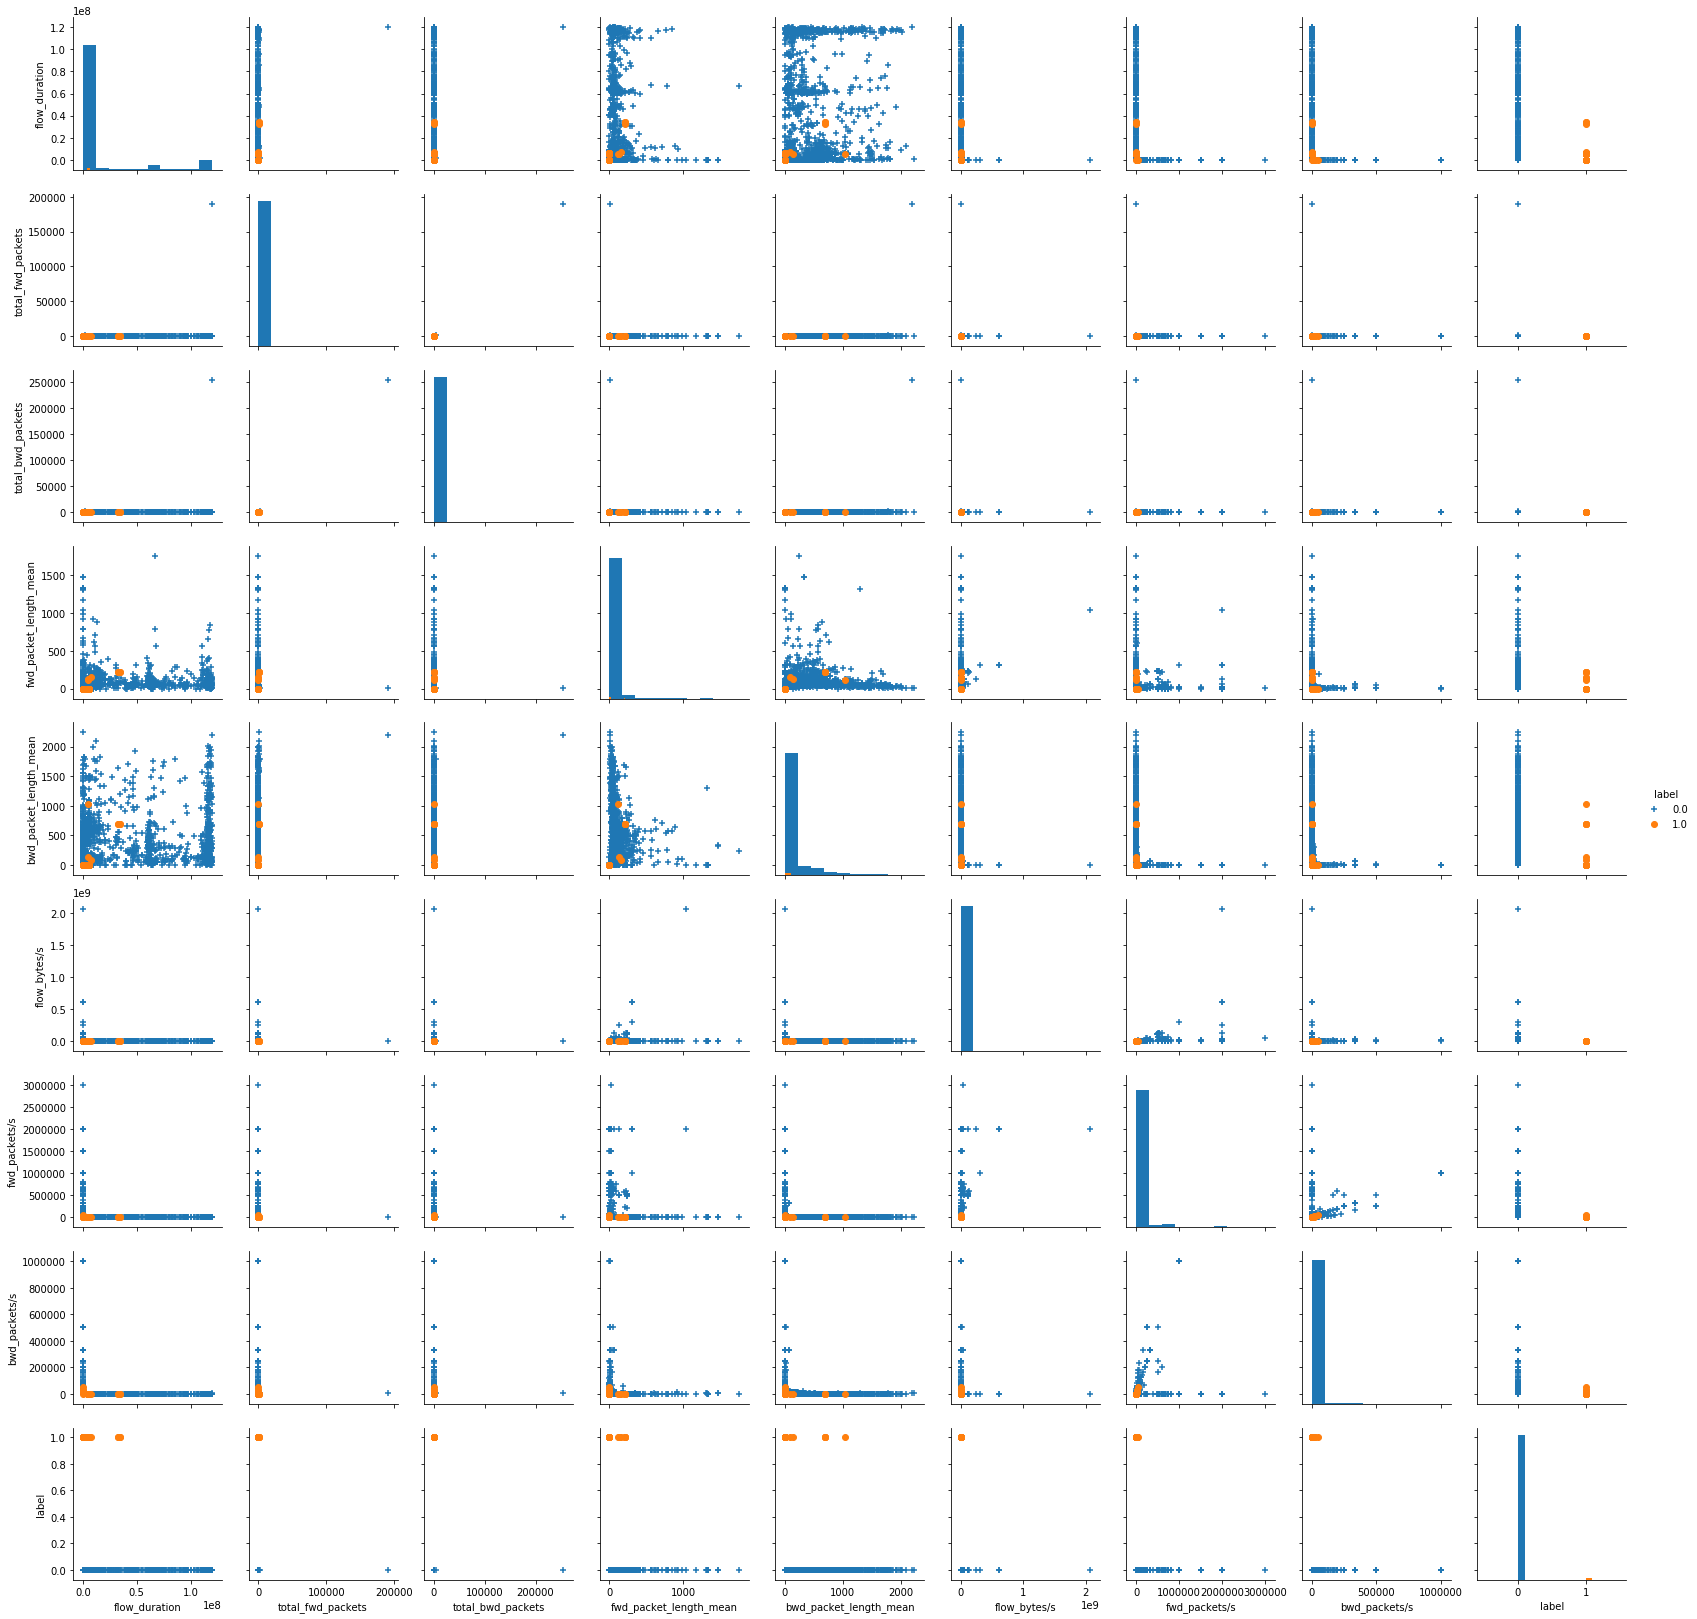

In [11]:
g = sns.PairGrid(scatter_df, hue="label", hue_kws={"marker": ["+", "o"]})
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

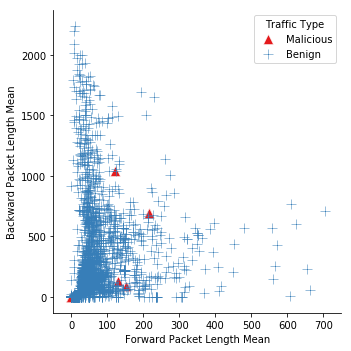

In [12]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5, hue_order=[1,0], hue_kws={"marker": ["^", "+"]})
g.map(plt.scatter, "fwd_packet_length_mean", "bwd_packet_length_mean", s=100, linewidth=.5, edgecolor="white")
plt.xlabel("Forward Packet Length Mean")
plt.ylabel("Backward Packet Length Mean")
plt.xlim(-50,750)
plt.legend(title='Traffic Type', loc='upper right', labels=['Malicious', 'Benign'])
plt.savefig("../figures/scatter_means.eps")
plt.savefig("../figures/scatter_means.png")
plt.show(g)

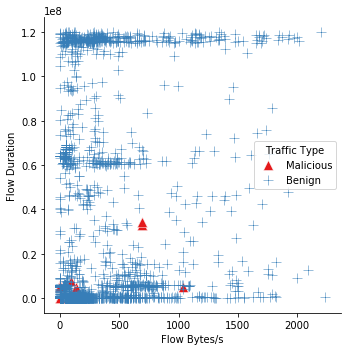

In [13]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5,hue_order=[1,0], hue_kws={"marker": ["^", "+"]}, legend_out = True)
g.map(plt.scatter, "bwd_packet_length_mean", "flow_duration", s=100, linewidth=.5, edgecolor="white")

# replace labels
plt.xlabel("Flow Bytes/s")
plt.ylabel("Flow Duration")
plt.legend(title='Traffic Type', loc='center right', labels=['Malicious', 'Benign'])
plt.savefig("../figures/scatter_bytes_duration.eps")
plt.savefig("../figures/scatter_bytes_duration.png")
plt.show(g)

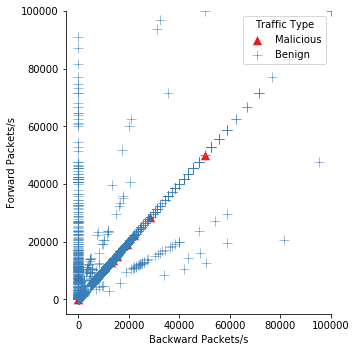

In [14]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5, hue_order=[1,0], hue_kws={"marker": ["^", "+"]}, legend_out = True)
g.map(plt.scatter, "bwd_packets/s", "fwd_packets/s", s=100, linewidth=.5, edgecolor="white")

# replace labels
plt.xlabel("Backward Packets/s")
plt.ylabel("Forward Packets/s")
plt.xlim(-5000,100000)
plt.ylim(-5000,100000)
plt.legend(title='Traffic Type', loc='upper right', labels=['Malicious', 'Benign'])
#plt.savefig("../figures/scatter_backwardPack_forwardPack.eps")
plt.show(g)

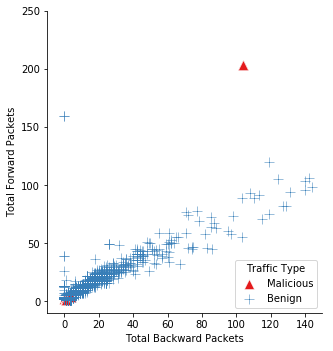

In [16]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5, hue_order=[1,0], hue_kws={"marker": ["^", "+"]}, legend_out = True)
g.map(plt.scatter, "total_bwd_packets", "total_fwd_packets", s=100, linewidth=.5, edgecolor="white")

# replace labels
plt.xlabel("Total Backward Packets")
plt.ylabel("Total Forward Packets")
plt.xlim(-10,150)
plt.ylim(-10,250)
plt.legend(title='Traffic Type', loc='lower right', labels=['Malicious', 'Benign'])
plt.savefig("../figures/scatter_backwardPack_forwardPack.eps")
plt.savefig("../figures/scatter_backwardPack_forwardPack.png")
plt.show(g)

## Model Fitting - Cross Validation

In [81]:
from sklearn.model_selection import StratifiedKFold
def grid_search_wrapper(X,y, model, param_grid, scorers,refit_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(model, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X, y)

    # make the predictions
    #y_pred = grid_search.predict(X_test.values)

    # confusion matrix on the test data.
    #print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    #print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                # columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search, refit_score

### Logistic Regression

In [94]:
min_cost = 0.0001
max_cost = 0.0025
# Cost vals for Logistic Regression, treated in LogR as inverse of regularization strength
lr_cost_grid = np.linspace(min_cost, max_cost,10)
weights = [1,5,10,50,100,1000]
lr_scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
    'f1_score' : make_scorer(f1_score)
}

lr_params = {
    'C' : lr_cost_grid,
    'class_weight' : ['balanced',{0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:50}, {0:1,1:100},{0:1,1:1000}]
}


"""
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
"""
log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=cost, n_jobs=-1)

start = time.time()
#for cost in cost_grid:
    # Create logisitic regression with the cost parameter and l1 penalty for LASSO
    #
   # log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=cost)

    #cross validate
   #cross_val = cross_validate(log_reg,
                   #X_nonTestScaled,
                   #y_nonTest, 
                  # cv=10,
                  #scoring='balanced_accuracy')
    #lr_balanced_accs.append(cross_val['test_score'].mean())
   # print(cost)
log_reg_grid_search,lr_refit = grid_search_wrapper(X_nonTestScaled, y_nonTest, log_reg,lr_params, lr_scorers, 'f1_score')


end = time.time()
print('Best params for {}'.format(lr_refit))
print(log_reg_grid_search.best_params_)

total = end - start
print("Total Time: ",total)

Best params for f1_score
{'C': 0.00036666666666666667, 'class_weight': {0: 1, 1: 50}}
Total Time:  520.8824300765991


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,params,split0_test_precision_score,split1_test_precision_score,split2_test_precision_score,...,split2_train_f1_score,split3_train_f1_score,split4_train_f1_score,split5_train_f1_score,split6_train_f1_score,split7_train_f1_score,split8_train_f1_score,split9_train_f1_score,mean_train_f1_score,std_train_f1_score
0,1.431021,0.105388,0.034269,0.005181,0.0001,balanced,"{'C': 0.0001, 'class_weight': 'balanced'}",0.019905,0.020249,0.019738,...,0.040214,0.039167,0.039528,0.03966,0.039777,0.039723,0.039537,0.039471,0.039763,0.000424
1,0.450194,0.118356,0.031151,0.009794,0.0001,"{0: 1, 1: 1}","{'C': 0.0001, 'class_weight': {0: 1, 1: 1}}",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.421026,0.118616,0.027914,0.001483,0.0001,"{0: 1, 1: 5}","{'C': 0.0001, 'class_weight': {0: 1, 1: 5}}",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.546466,0.083045,0.028299,0.001576,0.0001,"{0: 1, 1: 10}","{'C': 0.0001, 'class_weight': {0: 1, 1: 10}}",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.530571,0.066434,0.029381,0.005153,0.0001,"{0: 1, 1: 50}","{'C': 0.0001, 'class_weight': {0: 1, 1: 50}}",0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


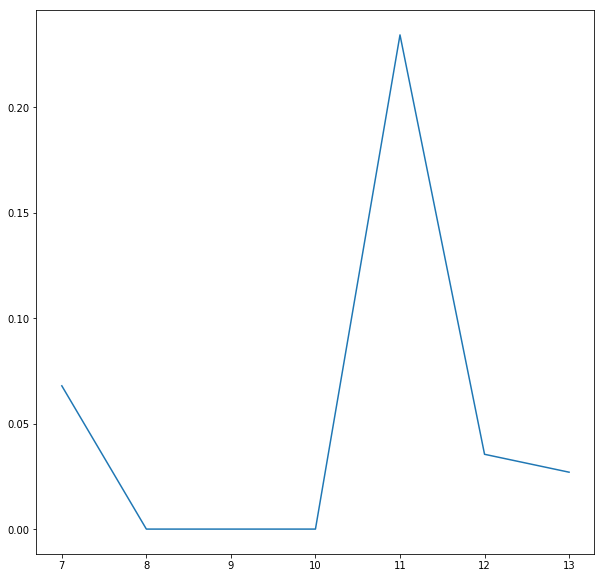

In [101]:
log_reg_grid_results_df = pd.DataFrame(log_reg_grid_search.cv_results_)
display(log_reg_grid_results_df.head(5))

fig = plt.figure(figsize=(10,10))
y = log_reg_grid_results_df['mean_test_f1_score'][log_reg_grid_results_df['param_C'] == 0.00036666666666666667]
plt.plot(y)
plt.show()

[0.667671405043462, 0.7578498276365201, 0.776486041386119, 0.7636256390295203, 0.7589421166361356, 0.752297354271646, 0.7479223476414323, 0.7433553354714701, 0.7403909134622306, 0.738326700899613]


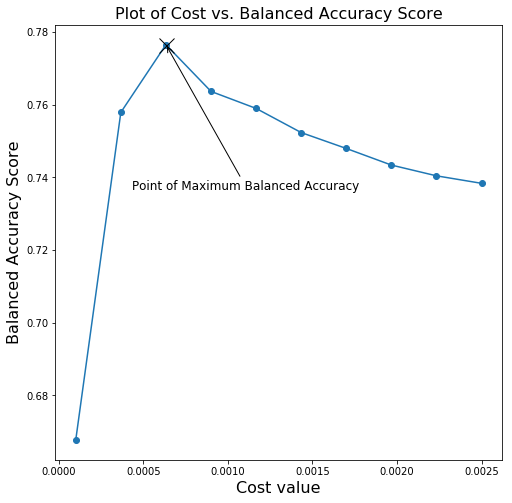

Best Cost 0.0006333333333333334
Max Balanced Accuracy 0.776486041386119


In [102]:
print(lr_balanced_accs)
best_bal_acc = np.max(lr_balanced_accs)
best_cost = cost_grid[np.argmax(lr_balanced_accs)]

fig = plt.figure(figsize=(8,8))
plt.plot(cost_grid,lr_balanced_accs, '-o')
plt.xlabel("Cost value", fontdict={'fontsize':16})
plt.ylabel("Balanced Accuracy Score", fontdict={'fontsize':16})
plt.title("Plot of Cost vs. Balanced Accuracy Score",  fontdict={'fontsize':16})
plt.plot(best_cost,best_bal_acc, marker = 'x',color='black',markersize=15)
plt.annotate('Point of Maximum Balanced Accuracy', xy=(best_cost,best_bal_acc), xytext=(best_cost-0.0002,best_bal_acc-.04), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", ec="black"), color='black', fontsize='large')
plt.savefig("../figures/lr_acc.eps")
plt.savefig("../figures/lr_acc.png")
plt.show()
print("Best Cost",best_cost)
print("Max Balanced Accuracy",best_bal_acc)

In [18]:
#Create Best LR model
best_log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=best_cost)

## K Nearest Neighbors

In [103]:
"""
#knn = None
#knn_bal_acc = []
#k_grid = np.arange(1,40+1,1)
#start = time.time()
#for k in k_grid:
#    knn = KNeighborsClassifier(n_neighbors=k,weights='uniform',n_jobs=4)
#    cross_val = cross_validate(knn,
 #                  X_nonTestScaled,
#                   y_nonTest, 
                   cv=10,
                  scoring='balanced_accuracy')
    knn_bal_acc.append(cross_val['test_score'].mean())
    print(k)
end =  time.time()

total = end - start
print(total)
"""
k_grid = np.arange(1,40+1,1)
knn_scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'balanced_accuracy_score': make_scorer(balanced_accuracy_score),
    'f1_score' : make_scorer(f1_score)
}

knn_params = {
    'n_neighbors' : k_grid,
    'weights' : ['uniform', 'distance']
}

knn = KNeighborsClassifier(n_jobs=-1)

start = time.time()
knn_grid_search,knn_refit = grid_search_wrapper(X_nonTestScaled, y_nonTest, knn,knn_params, knn_scorers, 'f1_score')


end = time.time()
print('Best params for {}'.format(knn_refit))
print(knn_grid_search.best_params_)

total = end - start
print("Total Time: ",total)


/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/ex

Best params for f1_score
{'n_neighbors': 27, 'weights': 'uniform'}
Total Time:  1965.4116787910461


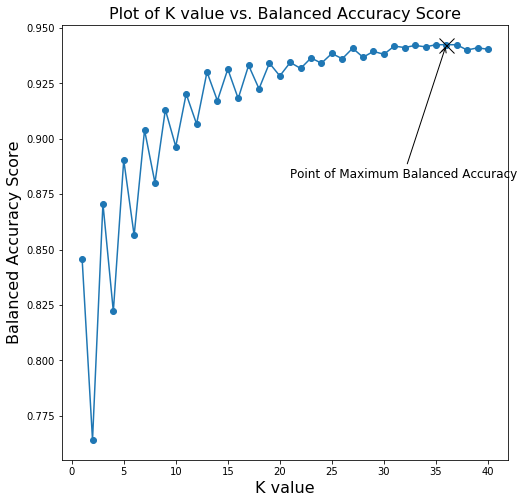

In [20]:
best_k = k_grid[np.argmax(knn_bal_acc)]
best_knn_bal_acc = np.max(knn_bal_acc)


fig = plt.figure(figsize=(8,8))
plt.plot(k_grid,knn_bal_acc, '-o')
plt.xlabel("K value", fontdict={'fontsize':16})
plt.ylabel("Balanced Accuracy Score", fontdict={'fontsize':16})
plt.title("Plot of K value vs. Balanced Accuracy Score",  fontdict={'fontsize':16})
plt.plot(best_k,best_knn_bal_acc, marker = 'x',color='black',markersize=15)
plt.annotate('Point of Maximum Balanced Accuracy', xy=(best_k,best_knn_bal_acc), xytext=(best_k-15,best_knn_bal_acc-.06), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", ec="black"), color='black', fontsize='large')
plt.savefig("../figures/knn_acc.eps")
plt.savefig("../figures/knn_acc.png")
plt.show()

## Balanced Random Forest

In [24]:
"""
    Performs balanced random forest classification with the given number of trees and returns
    mean balanced accuracy score from 10-fold cross validation.
"""
def find_num_estimators(n, X, y):
    brf = BRF(n_estimators=n,random_state=1, n_jobs=4, sampling_strategy=1.0,class_weight='balanced')
    cv = cross_validate(brf,
                   X,
                   y, 
                   cv=10,
                  scoring='balanced_accuracy',
                  n_jobs=4)
    return cv['test_score'].mean()
    

In [26]:
brf = BRF(random_state=1, n_jobs=-1, sampling_strategy='not majority', class_weight='balanced', replacement=True)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


#brf_bal_accs = [] #np.zeros((25,6))
#num_trees = np.arange(100,1000+1,100)
#start = time.time()
#for n in num_trees:
    #cv_ne_mean = find_num_estimators(n, X_nonTestScaled,y_nonTest)
    #brf_bal_accs.append(cv_ne_mean)
    #print(n)
#end = time.time()
#total = end - start
#print(total)

100
200
300
400
500
600
700
800
900
1000
449.10641264915466


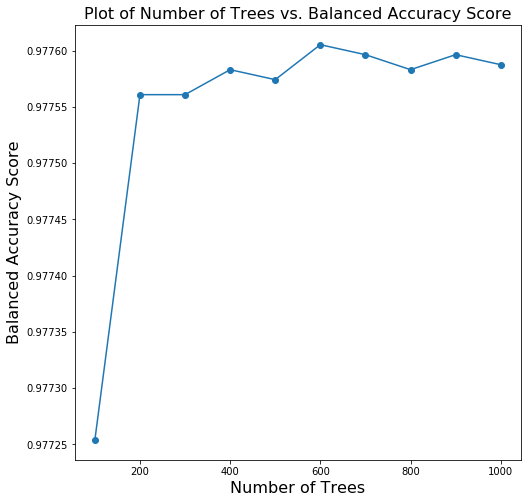

Number of Trees with highest Balanced Accuracy:  600


In [27]:
fig = plt.figure(figsize=(8,8))
plt.plot(num_trees,brf_bal_accs, '-o')
plt.xlabel("Number of Trees", fontdict={'fontsize':16})
plt.ylabel("Balanced Accuracy Score", fontdict={'fontsize':16})
plt.title("Plot of Number of Trees vs. Balanced Accuracy Score",  fontdict={'fontsize':16})
plt.savefig("../figures/num_trees_acc.eps")
plt.savefig("../figures/num_trees_acc.png")
plt.show()
best_num_trees = num_trees[np.argmax(brf_bal_accs)]
print("Number of Trees with highest Balanced Accuracy: ",best_num_trees)

### Tune max_features and max_depth

In [28]:
def find_depth_features(n, d, p, X, y):
    # Balanced Random Forest to sample to get 50/50 split between 1 and 0 class
    brf = BRF(n_estimators=n,max_depth=d, max_features=p, random_state=1, n_jobs=4,sampling_strategy=1.0, class_weight='balanced')
    cv = cross_validate(brf,
                   X,
                   y, 
                   cv=10,
                  scoring='balanced_accuracy',
                  n_jobs=4)
    return cv['test_score'].mean()

In [29]:

depths = np.arange(1,30+1,1)
features = np.arange(1,5+1,1)
hp_bal_accs = np.zeros((len(depths),len(features)))
start = time.time()
for d in range(len(depths)):
    for p in range(len(features)):
        cv_ne_mean = find_depth_features(best_num_trees,d+1,p+1, X_nonTestScaled,y_nonTest)
        hp_bal_accs[d,p] = cv_ne_mean
    print(d)
end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
7500.902672052383


Max Depth: 19
Max Features: 2


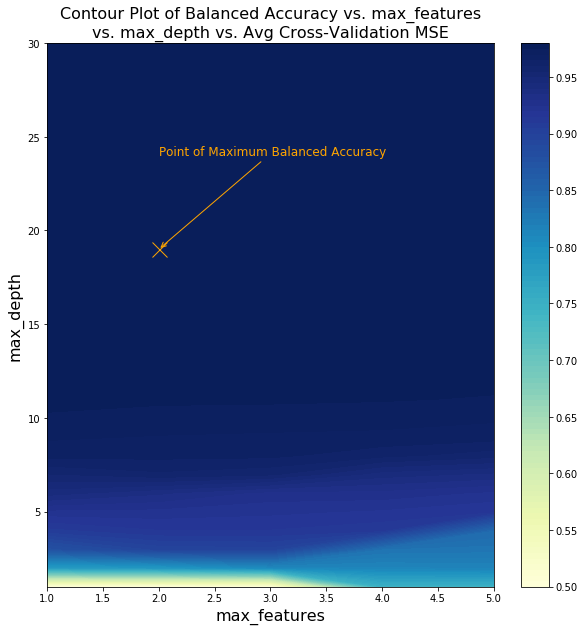

In [30]:
from textwrap import wrap
fig_contour = plt.figure(figsize=(10,10))
ax = plt.contourf(features, depths, hp_bal_accs,levels=100, cmap='YlGnBu')
cbar = fig_contour.colorbar(ax)
min_inds = np.unravel_index(np.argmax(hp_bal_accs, axis=None), hp_bal_accs.shape)
print("Max Depth: {}".format(min_inds[0]+1))
print("Max Features: {}".format(min_inds[1]+1))
plt.xlabel("max_features",fontdict={'fontsize':16})
plt.ylabel("max_depth",fontdict={'fontsize':16})
plt.title('\n'.join(wrap("Contour Plot of Balanced Accuracy vs. max_features vs. max_depth vs. Avg Cross-Validation MSE",50)), fontsize=16)
plt.plot(min_inds[1]+1,min_inds[0]+1,marker='x',color='orange', markersize=15)
plt.annotate('Point of Maximum Balanced Accuracy', xy=(min_inds[1]+1,min_inds[0]+1), xytext=(min_inds[1]+1,min_inds[0]+6), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", ec="orange"), color='orange', fontsize='large')
plt.savefig('../figures/countour_bal_acc.eps')
plt.savefig('../figures/countour_bal_acc.png')
plt.show()

In [31]:
m_depth=min_inds[0]+1
m_features=min_inds[1]+1

## Create best 3 models and cross validate

In [233]:
best_log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=best_cost)
best_knn = KNeighborsClassifier(n_neighbors=k,weights='uniform')
best_brf = BRF(n_estimators=best_num_trees,  max_depth=m_depth,max_features=m_features,random_state=1, sampling_strategy=1.0, 
                replacement=True)

cross_val_brf = cross_validate(best_brf,
                           X_nonTestScaled,
                           y_nonTest,
                           cv=10,
                          n_jobs=-1,
                          scoring=('balanced_accuracy','precision', 'recall', 'f1'))

cross_val_knn = cross_validate(best_knn,
                           X_nonTestScaled,
                           y_nonTest,
                           cv=10,
                           n_jobs=-1,
                          scoring=('balanced_accuracy','precision', 'recall', 'f1'))

cross_val_log_reg = cross_validate(best_log_reg,
                           X_nonTestScaled,
                           y_nonTest,
                           cv=10,
                           n_jobs=-1,
                          scoring=('balanced_accuracy','precision', 'recall', 'f1'))

knn_bal_accs = cross_val_knn['test_balanced_accuracy']
log_reg_bal_accs = cross_val_log_reg['test_balanced_accuracy']
brf_bal_accs = cross_val_brf['test_balanced_accuracy']
                               
knn_prec = cross_val_knn['test_precision']
log_reg_prec = cross_val_log_reg['test_precision']
brf_prec = cross_val_brf['test_precision']

In [234]:
knn_rec = cross_val_knn['test_recall']
log_reg_rec = cross_val_log_reg['test_recall']
brf_rec = cross_val_brf['test_recall']

knn_f1 = cross_val_knn['test_f1']
log_reg_f1 = cross_val_log_reg['test_f1']
brf_f1 = cross_val_brf['test_f1']

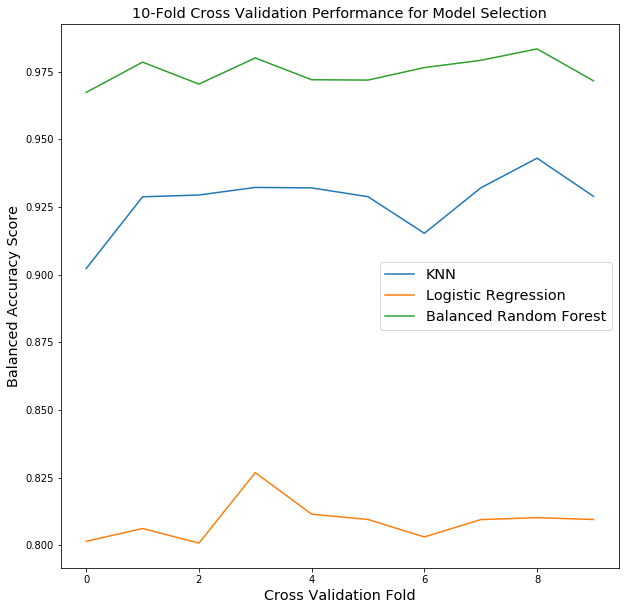

In [235]:
# Plot Model Cross Val Results
model_fig = plt.figure(figsize=(10,10))
plt.plot(knn_bal_accs)
plt.plot(log_reg_bal_accs)
plt.plot(brf_bal_accs)
plt.legend(['KNN', 'Logistic Regression','Balanced Random Forest'], fontsize='x-large')
plt.title("10-Fold Cross Validation Performance for Model Selection", fontsize='x-large')
plt.xlabel("Cross Validation Fold", fontsize='x-large')
plt.ylabel("Balanced Accuracy Score", fontsize='x-large')
plt.savefig("../figures/model_eval.eps")
plt.savefig("../figures/model_eval.png")
plt.show()

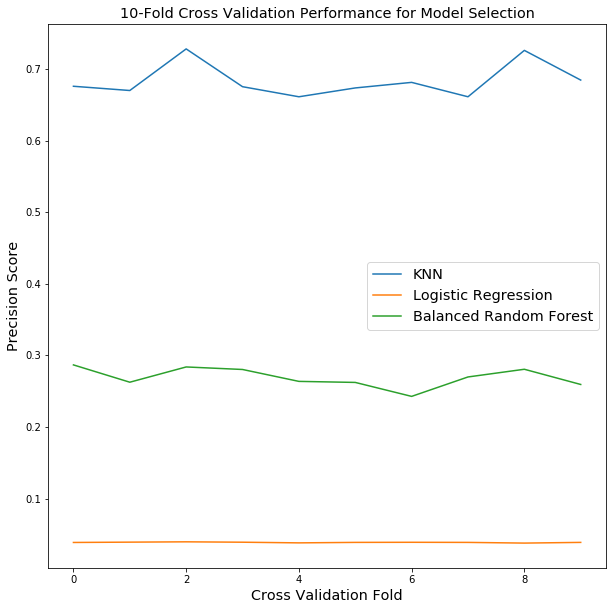

In [236]:
# Plot Model Cross Val Results
model_fig2 = plt.figure(figsize=(10,10))
plt.plot(knn_prec)
plt.plot(log_reg_prec)
plt.plot(brf_prec)
plt.legend(['KNN', 'Logistic Regression','Balanced Random Forest'], fontsize='x-large')
plt.title("10-Fold Cross Validation Performance for Model Selection", fontsize='x-large')
plt.xlabel("Cross Validation Fold", fontsize='x-large')
plt.ylabel("Precision Score", fontsize='x-large')
plt.savefig("../figures/model_eval_prec.eps")
plt.savefig("../figures/model_eval_prec.png")
plt.show()

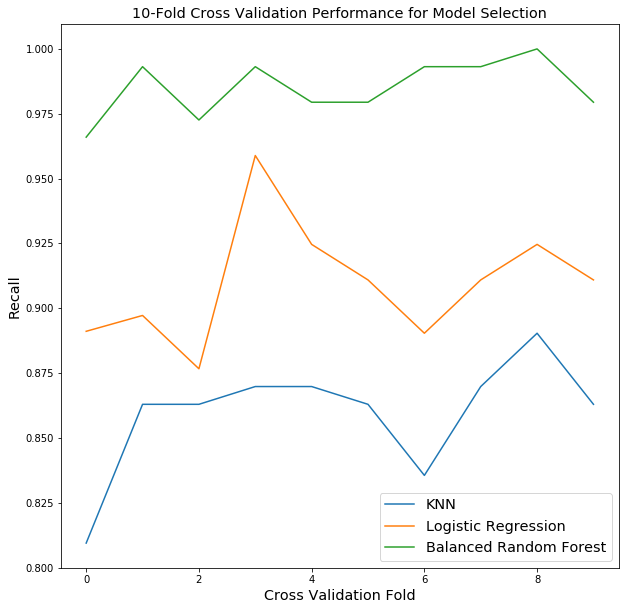

In [237]:
# Plot Model Cross Val Results
model_fig = plt.figure(figsize=(10,10))
plt.plot(knn_rec)
plt.plot(log_reg_rec)
plt.plot(brf_rec)
plt.legend(['KNN', 'Logistic Regression','Balanced Random Forest'], fontsize='x-large')
plt.title("10-Fold Cross Validation Performance for Model Selection", fontsize='x-large')
plt.xlabel("Cross Validation Fold", fontsize='x-large')
plt.ylabel("Recall", fontsize='x-large')
plt.savefig("../figures/model_eval_rec.eps")
plt.savefig("../figures/model_eval_rec.png")
plt.show()

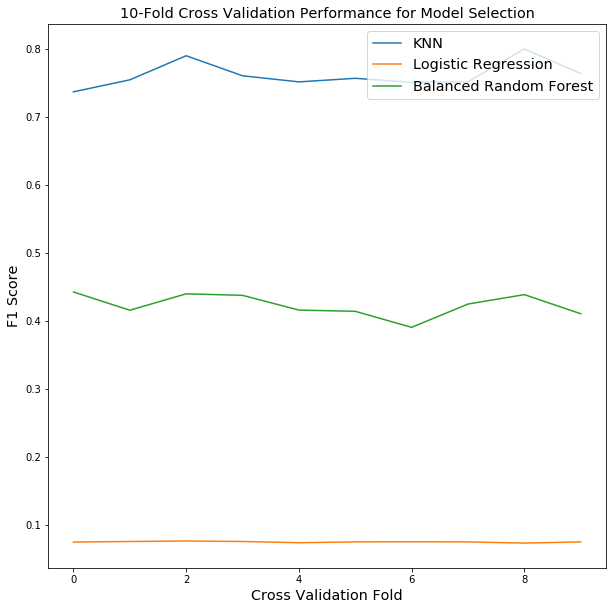

In [238]:
# Plot Model Cross Val Results
model_fig = plt.figure(figsize=(10,10))
plt.plot(knn_f1)
plt.plot(log_reg_f1)
plt.plot(brf_f1)
plt.legend(['KNN', 'Logistic Regression','Balanced Random Forest'], fontsize='x-large')
plt.title("10-Fold Cross Validation Performance for Model Selection", fontsize='x-large')
plt.xlabel("Cross Validation Fold", fontsize='x-large')
plt.ylabel("F1 Score", fontsize='x-large')
plt.savefig("../figures/model_eval_f1.eps")
plt.savefig("../figures/model_eval_f1.png")
plt.show()

In [17]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    Taken from: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    return [1 if y >= t else 0 for y in y_scores]

def getPRdata(truthVals,probs,thresholds):
    num_samples = len(thresholds)
    pr_data_columns = ['prob_threshold', 'TP_count', 'FP_count', 'TN_count', 'FN_count', 'TP_rate',
                       'FP_rate', 'accuracy', 'precision', 'F-measure']
    pr_data_df = pd.DataFrame(np.zeros((num_samples, len(pr_data_columns)), dtype=float),
                               columns = pr_data_columns)
    
    # calculate values
    curr_entry = []  
    position = 0
    for curr_prob in thresholds:
        # Variables
        tp_count = 0
        fp_count = 0
        tn_count = 0
        fn_count = 0
        tp_rate = 0.
        fp_rate = 0.
        accuracy = 0.
        precision = 0.
        f_measure = 0.
        predict_prob = 0.0
        #end variable declarations
        counter = 0
        for val in truthVals:
            predict_prob = probs[counter]
            if (val == 0):
                if(predict_prob >= curr_prob):
                    fp_count += 1 #Truth val neg, predict pos: false positive
                else:
                    tn_count += 1 #Truth val neg, predict neg: true negative 
            else:
                if(predict_prob >= curr_prob):
                    tp_count += 1 # truth val positive, predict pos: true positive
                else:
                    fn_count += 1 # truth val positive, predict neg: false negative
            counter += 1
         #End for
        tp_rate = tp_count/(tp_count + fn_count)
        fp_rate = fp_count/(tn_count + fp_count)
        accuracy = (tn_count + tp_count)/(tp_count + tn_count + fp_count + fn_count)
        precision = tp_count/(tp_count + fp_count)
        f_measure = (2*tp_rate*precision)/(precision + tp_rate)
    
        # Add values to dataframe
        pr_data_df.at[position, 'prob_threshold'] = curr_prob
        pr_data_df.at[position, 'TP_count'] = tp_count
        pr_data_df.at[position, 'FP_count'] = fp_count
        pr_data_df.at[position, 'TN_count'] = tn_count
        pr_data_df.at[position, 'FN_count'] = fn_count
        pr_data_df.at[position, 'TP_rate'] = tp_rate
        pr_data_df.at[position, 'FP_rate'] = fp_rate
        pr_data_df.at[position, 'accuracy'] = accuracy
        pr_data_df.at[position, 'precision'] = precision
        pr_data_df.at[position, 'F-measure'] = f_measure
        
        position += 1
    #End for  
    return pr_data_df

In [20]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_curve as PRC

# Fit Best BRF Model on all nonTest data
#best_brf.fit(X_nonTestScaled, y_nonTest)
best_brf = BRF(n_estimators=600,  max_depth=19,max_features=2,random_state=1, sampling_strategy=1.0, 
                replacement=True)

small_X_nonTest, small_X_val, small_y_nonTest, small_y_val = train_test_split(X_nonTestScaled, y_nonTest, test_size=test_ratio, random_state=1, stratify=y_nonTest)
small_X_nonTest = np.array(small_X_nonTest)
small_y_nonTest = np.array(small_y_nonTest)
best_brf.fit(small_X_nonTest, small_y_nonTest)
# Predict on val set
y_val_prob_pred = best_brf.predict_proba(small_X_val)

precision, recall, thresholds = PRC(small_y_val, y_val_prob_pred[:,1])
#plt.plot(rec, prec)
#plt.show()

In [230]:

#
#plt.plot(rec_list,prec_list)
#

In [48]:
thresholds = np.linspace(np.min(y_val_prob_pred[:,1]), np.max(y_val_prob_pred[:,1]),100)
PR_data_df = getPRdata(small_y_val, y_val_prob_pred[:,1], thresholds)
display(PR_data_df.head(40))


,prob_threshold,TP_count,FP_count,TN_count,FN_count,TP_rate,FP_rate,accuracy,precision,F-measure
0,0.000000,482.0,37156.0,0.0,0.0,1.000000,1.000000,0.012806,0.012806,0.025289
1,0.010101,482.0,9201.0,27955.0,0.0,1.000000,0.247632,0.755540,0.049778,0.094835
2,0.020202,482.0,7845.0,29311.0,0.0,1.000000,0.211137,0.791567,0.057884,0.109434
3,0.030303,482.0,6621.0,30535.0,0.0,1.000000,0.178195,0.824087,0.067859,0.127093
4,0.040404,482.0,5729.0,31427.0,0.0,1.000000,0.154188,0.847787,0.077604,0.144031
5,0.050505,482.0,5339.0,31817.0,0.0,1.000000,0.143691,0.858149,0.082804,0.152943
6,0.060606,482.0,5010.0,32146.0,0.0,1.000000,0.134837,0.866890,0.087764,0.161366
7,0.070707,482.0,4782.0,32374.0,0.0,1.000000,0.128701,0.872948,0.091565,0.167769
8,0.080808,482.0,4572.0,32584.0,0.0,1.000000,0.123049,0.878527,0.095370,0.174133
9,0.090909,482.0,4290.0,32866.0,0.0,1.000000,0.115459,0.886019,0.101006,0.183479


In [49]:
print(np.argmax(PR_data_df['F-measure']))

89


/home/mnewlin/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


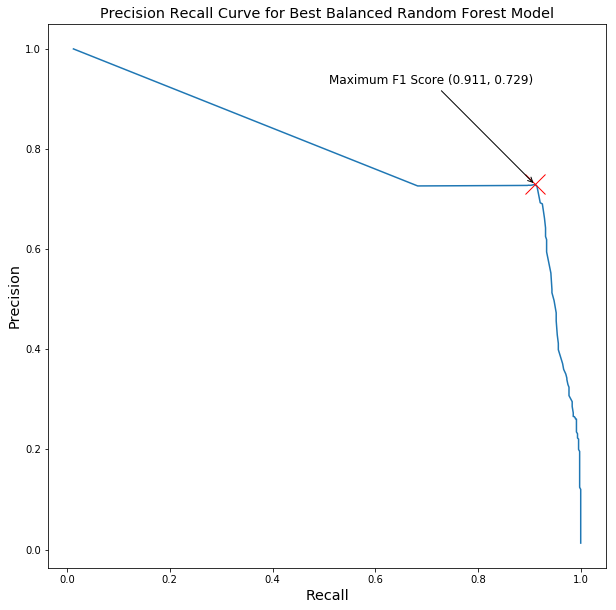

In [50]:
plt.figure(figsize=(10,10))
plt.plot(PR_data_df['TP_rate'],PR_data_df['precision'])
plt.xlabel("Recall", fontsize='x-large')
plt.ylabel("Precision", fontsize='x-large')
plt.title('Precision Recall Curve for Best Balanced Random Forest Model', fontsize='x-large')
best_f_x = PR_data_df.iloc[89,5]
best_f_y = PR_data_df.iloc[89,8]
plt.plot(best_f_x, best_f_y, marker='x',color='red', markersize=20)
plt.annotate('Maximum F1 Score ({:.3f}, {:.3f})'.format(best_f_x, best_f_y), xy=(best_f_x, best_f_y), xytext=(best_f_x-0.4, best_f_y+0.2), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='large')
plt.savefig('../figures/pr_curve_cv.eps')
plt.savefig('../figures/pr_curve_cv.png')
plt.show()

In [51]:

best_prob = PR_data_df.iloc[89,0]
y_pred_val_class = adjusted_classes(y_val_prob_pred[:,1], best_prob)

cm_val = confusion_matrix(small_y_val, y_pred_val_class)
cm_val_df = pd.DataFrame(cm_val)
display(cm_val_df)

,0,1
0,36993,163
1,43,439


In [52]:
def area_under_roc_curve(y_vec):
    n = len(y_vec)
    h = 1/n
    total_area = 0.
    y_vec = np.sort(y_vec)
    for y in y_vec:
        area = y*h
        total_area += area
    # End for
    return total_area

## Predict on Test Data

In [53]:
from sklearn.metrics import auc

area_under_pr_curve = auc(PR_data_df['TP_rate'], PR_data_df['precision'])
print(area_under_pr_curve)
# fit on all nontest data
best_brf.fit(X_nonTestScaled, y_nonTest)

y_pred_prob = best_brf.predict_proba(X_testScaled)

y_pred_adj = adjusted_classes(y_pred_prob[:,1], best_prob)


cm = confusion_matrix(y_test, y_pred_adj)
cm_df = pd.DataFrame(cm)
display(cm_df)



0.7850269978870736


,0,1
0,55242,216
1,67,652


In [54]:
test_rec = recall_score(y_test, y_pred_adj)
test_prec = precision_score(y_test, y_pred_adj)
test_f1 = f1_score(y_test, y_pred_adj)
test_bal_acc = balanced_accuracy_score(y_test, y_pred_adj)

print("Recall: {}".format(test_rec))
print("Precision: {}".format(test_prec))
print("f1: {}".format(test_f1))
print("balanced accuracy: {}".format(test_bal_acc))

Recall: 0.9068150208623088
Precision: 0.7511520737327189
f1: 0.821676118462508
balanced accuracy: 0.9514600907622157


In [55]:
test_thresholds = np.linspace(np.min(y_pred_prob[:,1]), np.max(y_pred_prob[:,1]),100)
test_PR_data_df = getPRdata(y_test, y_pred_prob[:,1], test_thresholds)

Area under test PR Curve 0.804301502430114


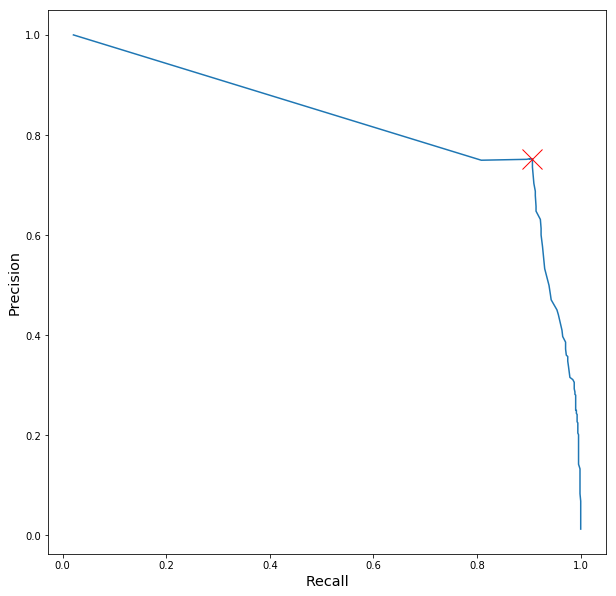

In [59]:
print("Area under test PR Curve",auc(test_PR_data_df['TP_rate'], test_PR_data_df['precision']))
fig = plt.figure(figsize=(10,10))
plt.plot(test_PR_data_df['TP_rate'],test_PR_data_df['precision'])
plt.xlabel("Recall", fontsize='x-large')
plt.ylabel("Precision", fontsize='x-large')
#plt.title('Precision Recall Curve for Best Balanced Random Forest Model', fontsize='x-large')
#best_f_x = PR_data_df.iloc[89,5]
#best_f_y = PR_data_df.iloc[89,8]
plt.plot(test_rec, test_prec, marker='x',color='red', markersize=20)
#plt.annotate('Maximum F1 Score ({:.3f}, {:.3f})'.format(best_f_x, best_f_y), xy=(best_f_x, best_f_y), xytext=(best_f_x-0.4, best_f_y+0.2), 
            # arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize='large')
plt.savefig('../figures/pr_curve_test.eps')
plt.savefig('../figures/pr_curve_test.png')
plt.show()

In [28]:
features_and_importances = pd.DataFrame([actual_data.columns,best_brf.feature_importances_], index=['Feature', 'Importance']).transpose()
features_and_importances = features_and_importances.sort_values(by=['Importance'],ascending=False)
display(md("#### Features and Importance"))
display(features_and_importances)

#### Features and Importance

,Feature,Importance
3,fwd_packet_length_mean,0.257993
5,flow_bytes/s,0.168158
0,flow_duration,0.142346
6,fwd_packets/s,0.134821
4,bwd_packet_length_mean,0.0914444
1,total_fwd_packets,0.0849851
7,bwd_packets/s,0.0745004
2,total_bwd_packets,0.0457521


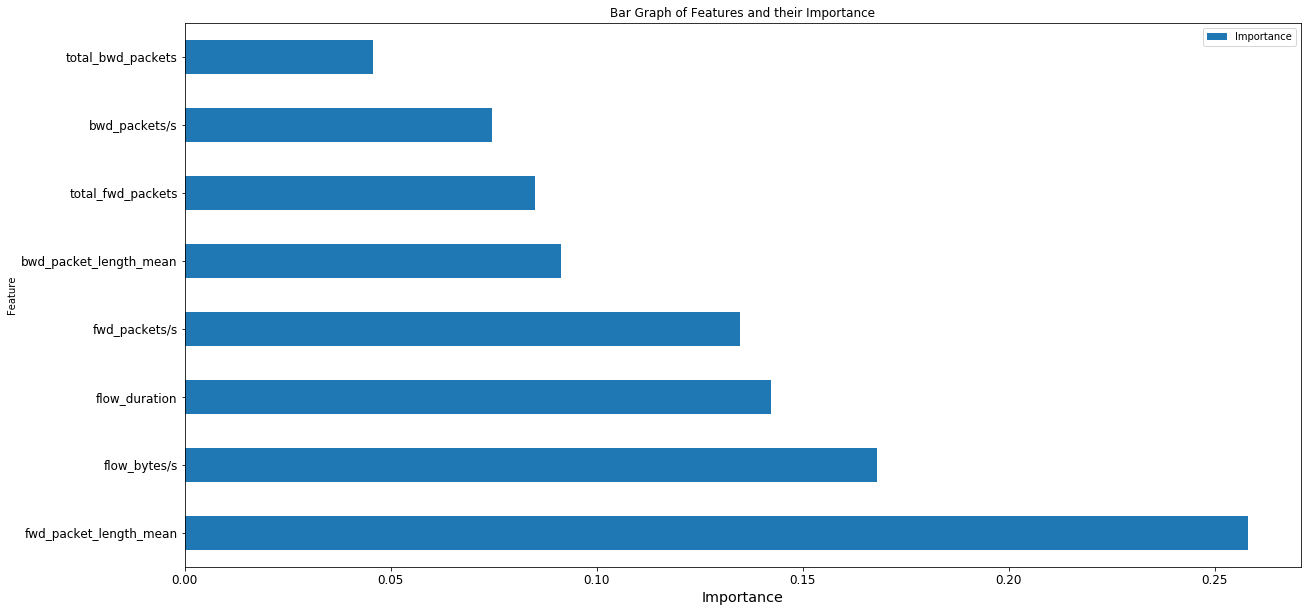

In [42]:
from textwrap import wrap
features_and_importances.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])
ax=features_and_importances.plot.barh('Feature', figsize=(20,10), fontsize='large')
#plt.figure(figsize=(10,10))
#plt.barh(features_and_importances['Feature'], width=1,  wrap=True)
plt.title("Bar Graph of Features and their Importance")
plt.xlabel("Importance", fontsize='x-large')
plt.savefig('../figures/feature_importance.eps')
plt.savefig('../figures/feature_importance.png')
plt.show()

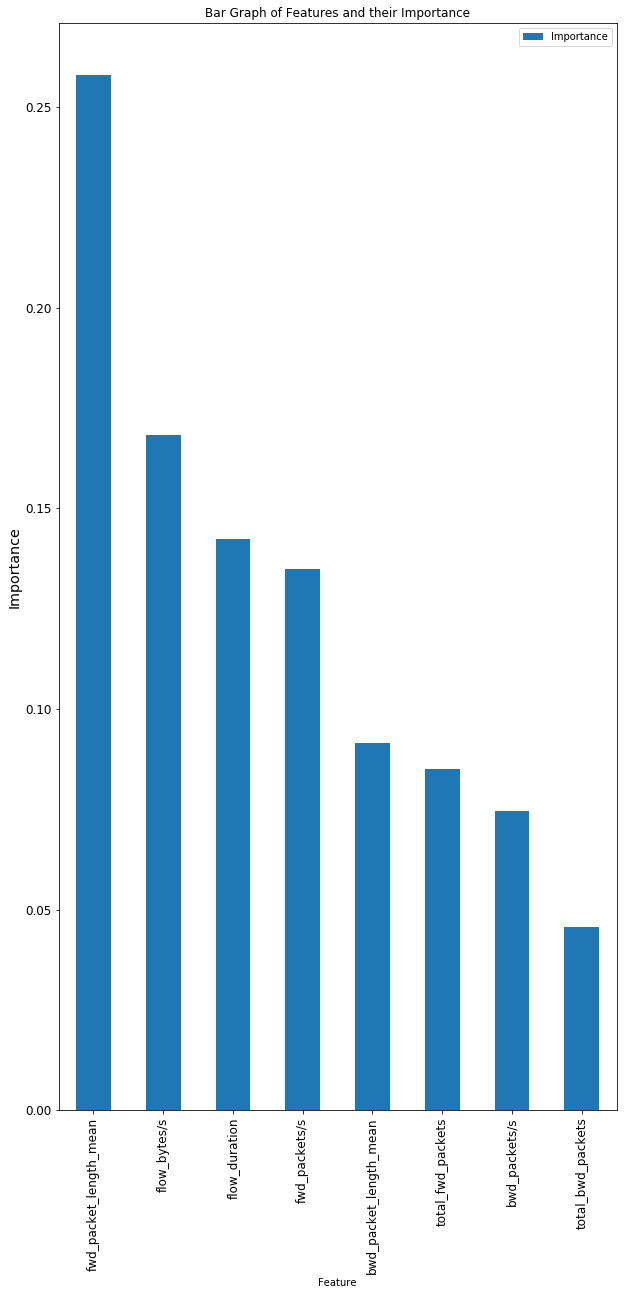

In [47]:
ax=features_and_importances.plot.bar('Feature', figsize=(10,20), fontsize='large')
#plt.figure(figsize=(10,10))
#plt.barh(features_and_importances['Feature'], width=1,  wrap=True)
plt.title("Bar Graph of Features and their Importance")
plt.ylabel("Importance", fontsize='x-large')
plt.savefig('../figures/feature_importance_vert.eps')
plt.savefig('../figures/feature_importance_vert.png')
plt.show()